In [2]:
# Replace with your file path
file_path = 'https://tayweid.github.io/econ-0150/parts/part-6-1/data/'
file_path = 'drive/MyDrive/TEACHING/ECON_0150/Part_6/'

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn   as sns
import sys


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Research Question

*Is unemployment related to voter turnout by county?*

### Load Elections Data

*Data collected from electionlab.mit.edu*.

In [15]:
elections = pd.read_csv(file_path + 'countypres_2000-2020.csv')

# Set FIPS as index
elections = elections.dropna()
elections.index = elections.county_fips.astype(int).astype(str)

# Print header
elections.head()

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
county_fips,,,,,,,,,,,,
1001,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,AL GORE,DEMOCRAT,4942,17208,20220315,TOTAL
1001,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,GEORGE W. BUSH,REPUBLICAN,11993,17208,20220315,TOTAL
1001,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,RALPH NADER,GREEN,160,17208,20220315,TOTAL
1001,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,OTHER,OTHER,113,17208,20220315,TOTAL
1003,2000,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,AL GORE,DEMOCRAT,13997,56480,20220315,TOTAL


### Load Census Data

In [17]:
#df = pd.read_csv(file_path + 'usa_00043_formatted.csv', index_col=0)

# Drop nan values
#df = df[~df.COUNTYFIP.isna()]

# Construct county_fips: STATEFIP + COUNTYFIP with STATEFIP
#df['county_fips'] = df.STATEFIP.astype(int).astype(str) + df.COUNTYFIP.astype(int).astype(str).str.zfill(3)

# Create indicator variable for unemployed
#df['unemployed'] = (df['EMPSTAT'] == 2)*1

# Drop N/A or unknown
#df = df[df['INCTOT'] < 9999998]

In [37]:
# Summarize average SEX, AGE, EMPSTATD, and INCTOT by county_fips
county = df.groupby(['county_fips', 'YEAR'])[['SEX', 'AGE', 'unemployed']].mean()
county['unemployed'] = county['unemployed'] * 100
county['med_inc'] = df.groupby(['county_fips', 'YEAR'])[['INCTOT']].median()
county['pop'] = df.groupby(['county_fips', 'YEAR'])[['PERWT']].sum()
county = county.reset_index(level='YEAR')

county.to_csv(file_path + 'usa_00043_county.csv')

In [38]:
county = pd.read_csv(file_path + 'usa_00043_county.csv', index_col=0)
county.head()

,YEAR,SEX,AGE,unemployed,med_inc,pop
county_fips,,,,,,
1000,2007,1.528807,48.180949,3.290372,17000.0,2149584.0
1000,2011,1.522652,48.966183,5.713311,15800.0,2250941.0
1000,2015,1.523972,49.649278,3.608744,18000.0,2438898.0
1000,2019,1.524781,50.154590,2.279030,21555.0,2464639.0
10001,2007,1.535065,45.457143,2.943723,22300.0,124513.0


## Do areas with higher unemployment have higher voter turnout rates?

Lets start with the 2012 presidential election.

In [41]:
e2012 = elections[elections.year == 2012]
e2012.head()

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
county_fips,,,,,,,,,,,,
1001,2012,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,BARACK OBAMA,DEMOCRAT,6363,23932,20220315,TOTAL
1001,2012,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,MITT ROMNEY,REPUBLICAN,17379,23932,20220315,TOTAL
1001,2012,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,OTHER,OTHER,190,23932,20220315,TOTAL
1003,2012,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,BARACK OBAMA,DEMOCRAT,18424,85338,20220315,TOTAL
1003,2012,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,MITT ROMNEY,REPUBLICAN,66016,85338,20220315,TOTAL


In [50]:
e2012.index = e2012.county_fips.astype(int)

In [49]:
e2012.index

Index(['1001.0', '1001.0', '1001.0', '1003.0', '1003.0', '1003.0', '1005.0',
       '1005.0', '1005.0', '1007.0',
       ...
       '2038.0', '2039.0', '2039.0', '2039.0', '2040.0', '2040.0', '2040.0',
       '2099.0', '2099.0', '2099.0'],
      dtype='object', name='county_fips', length=9465)

In [44]:
c2011 = county[county.YEAR == 2011]
c2011.index

Index([ 1000, 10001, 10003, 10005,  1003,  1015,  1055,  1073,  1081,  1097,
       ...
        8041,  8123,  9001,  9003,  9005,  9007,  9009,  9011,  9013,  9015],
      dtype='int64', name='county_fips', length=424)

In [51]:
# Merge
data = e2012.merge(c2011, left_index=True, right_index=True)

# Create turnout
data['turnout'] = 100 * data['totalvotes'] / data['pop']

# Header
data.head()

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode,YEAR,SEX,AGE,unemployed,med_inc,pop,turnout
county_fips,,,,,,,,,,,,,,,,,,,
1003,2012,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,BARACK OBAMA,DEMOCRAT,18424,85338,20220315,TOTAL,2011,1.514166,49.435467,4.616999,19900.0,150677.0,56.636381
1003,2012,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,MITT ROMNEY,REPUBLICAN,66016,85338,20220315,TOTAL,2011,1.514166,49.435467,4.616999,19900.0,150677.0,56.636381
1003,2012,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,OTHER,OTHER,898,85338,20220315,TOTAL,2011,1.514166,49.435467,4.616999,19900.0,150677.0,56.636381
1015,2012,ALABAMA,AL,CALHOUN,1015.0,US PRESIDENT,BARACK OBAMA,DEMOCRAT,15511,46257,20220315,TOTAL,2011,1.538117,47.110987,5.829596,14450.0,95231.0,48.573469
1015,2012,ALABAMA,AL,CALHOUN,1015.0,US PRESIDENT,MITT ROMNEY,REPUBLICAN,30278,46257,20220315,TOTAL,2011,1.538117,47.110987,5.829596,14450.0,95231.0,48.573469


#### Step 1. Start by summarizing the variables.

#### Step 2. Show the main relationship.

#### Step 3. Model the relationship:

$$\text{turnout} = \beta_0 + \beta_1 \text{unemployment} + \epsilon$$

In [55]:
# use statsmodelsfunctions to run a regression of this relationship
model = smf.ols(formula='turnout ~ unemployed', data=data).fit()
#print(model.summary().tables[1])

#### Step 4. Residuals

## Did areas with an increase in unemployment increase their turnout rate?

In [ ]:
# create county datasets for 2007, 2011, 2015, 2019

for year, yeardf in zip([2007, 2011, 2015, 2019], [df2007, df2011, df2015, df2019]):
  # summarize average SEX, AGE, EMPSTATD, and INCTOT by county_fips

  cdfyear = yeardf.groupby('county_fips')[['SEX', 'AGE', 'unemployed']].mean()
  cdfyear['med_inc'] = yeardf.groupby('county_fips')[['INCTOT']].median()
  cdfyear['pop'] = yeardf.groupby('county_fips')[['PERWT']].sum()
  cdfyear.to_csv(file_path + 'c' + str(year) + '.csv')

#### Create a county dataset in 2016

In [ ]:
# summarize average SEX, AGE, EMPSTATD, and INCTOT by county_fips

c2015 = df2015.groupby('county_fips')[['SEX', 'AGE', 'unemployed']].mean()
c2015['med_inc'] = df2015.groupby('county_fips')[['INCTOT']].median()
c2015['pop'] = df2015.groupby('county_fips')[['PERWT']].sum()

#### Create a county dataset in 2012

In [ ]:
# summarize average SEX, AGE, EMPSTATD, and INCTOT by county_fips

c2011 = df2011.groupby('county_fips')[['SEX', 'AGE', 'unemployed']].mean()
c2011['med_inc'] = df2011.groupby('county_fips')[['INCTOT']].median()
c2011['pop'] = df2011.groupby('county_fips')[['PERWT']].sum()

#### Create a county dataset in 2008

In [ ]:
# summarize average SEX, AGE, EMPSTATD, and INCTOT by county_fips

c2007 = df2007.groupby('county_fips')[['SEX', 'AGE', 'unemployed']].mean()
c2007['med_inc'] = df2007.groupby('county_fips')[['INCTOT']].median()
c2007['pop'] = df2007.groupby('county_fips')[['PERWT']].sum()

#### Merge county data in 2008 and 2012 to create a difference

In [ ]:
c0711 = c2007.merge(c2011, left_index=True, right_index=True, suffixes=('_2007', '_2011'))
c0711['delta_unemployed'] = c0711['unemployed_2011'] - c0711['unemployed_2007']

#### Merge county data in 2012 and 2016 to create a difference

In [ ]:
c1115 = c2011.merge(c2015, left_index=True, right_index=True, suffixes=('_2011', '_2015'))
c1115['delta_unemployed'] = c1115['unemployed_2015'] - c1115['unemployed_2011']

#### Merge election data in 2012 and 2008 to create a difference

In [ ]:
e0812 = e2008.merge(e2012, left_index=True, right_index=True, suffixes=('_2008', '_2012'))

In [ ]:
e1216 = e2012.merge(e2016, left_index=True, right_index=True, suffixes=('_2012', '_2016'))

#### Merge 2012

In [ ]:
# merge elections and counties on index

del_12 = e0812.merge(c0711, left_index=True, right_index=True)
del_12['turnout_2012'] = del_12['totalvotes_2012'] / del_12['pop_2011']
del_12['turnout_2008'] = del_12['totalvotes_2008'] / del_12['pop_2007']
del_12['delta_turnout'] = del_12['turnout_2012'] - del_12['turnout_2008']
del_12.head()

,year_2008,state_2008,state_po_2008,county_name_2008,county_fips_2008,office_2008,candidate_2008,party_2008,candidatevotes_2008,totalvotes_2008,...,pop_2007,SEX_2011,AGE_2011,unemployed_2011,med_inc_2011,pop_2011,delta_unemployed,turnout_2012,turnout_2008,delta_turnout
county_fips,,,,,,,,,,,,,,,,,,,,,
1003,2008,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,BARACK OBAMA,DEMOCRAT,19386,81413,...,140266.0,1.514166,49.435467,0.04617,19900.0,150677.0,0.023327,0.566364,0.580419,-0.014055
1003,2008,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,BARACK OBAMA,DEMOCRAT,19386,81413,...,140266.0,1.514166,49.435467,0.04617,19900.0,150677.0,0.023327,0.566364,0.580419,-0.014055
1003,2008,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,BARACK OBAMA,DEMOCRAT,19386,81413,...,140266.0,1.514166,49.435467,0.04617,19900.0,150677.0,0.023327,0.566364,0.580419,-0.014055
1003,2008,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,JOHN MCCAIN,REPUBLICAN,61271,81413,...,140266.0,1.514166,49.435467,0.04617,19900.0,150677.0,0.023327,0.566364,0.580419,-0.014055
1003,2008,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,JOHN MCCAIN,REPUBLICAN,61271,81413,...,140266.0,1.514166,49.435467,0.04617,19900.0,150677.0,0.023327,0.566364,0.580419,-0.014055


#### Merge 2016

In [ ]:
# merge elections and counties on index

del_16 = e1216.merge(c1115, left_index=True, right_index=True)
del_16['turnout_2016'] = del_16['totalvotes_2016'] / del_16['pop_2015']
del_16['turnout_2012'] = del_16['totalvotes_2012'] / del_16['pop_2011']
del_16['delta_turnout'] = del_16['turnout_2016'] - del_16['turnout_2012']
del_16.head()

,year_2012,state_2012,state_po_2012,county_name_2012,county_fips_2012,office_2012,candidate_2012,party_2012,candidatevotes_2012,totalvotes_2012,...,pop_2011,SEX_2015,AGE_2015,unemployed_2015,med_inc_2015,pop_2015,delta_unemployed,turnout_2016,turnout_2012,delta_turnout
county_fips,,,,,,,,,,,,,,,,,,,,,
1003,2012,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,BARACK OBAMA,DEMOCRAT,18424,85338,...,150677.0,1.502564,52.226496,0.023077,24000.0,166643.0,-0.023093,0.571371,0.566364,0.005007
1003,2012,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,BARACK OBAMA,DEMOCRAT,18424,85338,...,150677.0,1.502564,52.226496,0.023077,24000.0,166643.0,-0.023093,0.571371,0.566364,0.005007
1003,2012,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,BARACK OBAMA,DEMOCRAT,18424,85338,...,150677.0,1.502564,52.226496,0.023077,24000.0,166643.0,-0.023093,0.571371,0.566364,0.005007
1003,2012,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,MITT ROMNEY,REPUBLICAN,66016,85338,...,150677.0,1.502564,52.226496,0.023077,24000.0,166643.0,-0.023093,0.571371,0.566364,0.005007
1003,2012,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,MITT ROMNEY,REPUBLICAN,66016,85338,...,150677.0,1.502564,52.226496,0.023077,24000.0,166643.0,-0.023093,0.571371,0.566364,0.005007


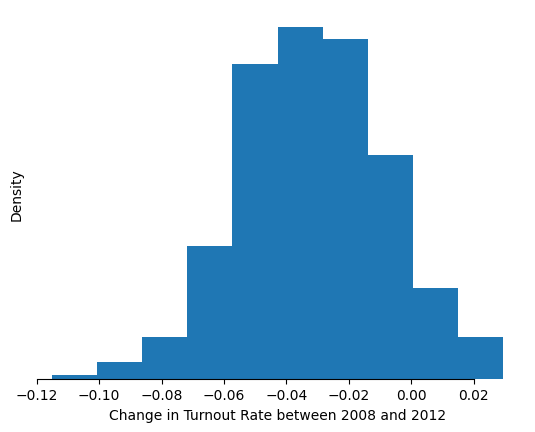

In [ ]:
del_12.delta_turnout.hist()
# add xlabel
plt.xlabel('Change in Turnout Rate between 2008 and 2012')
# remove the grid
plt.grid(False)
# despine
sns.despine(top=True, right=True, left=True, trim=10)
# remove ylabel and ticks
plt.yticks([])
plt.ylabel('Density')
plt.savefig(file_path + 'turnout_change_2012.png')

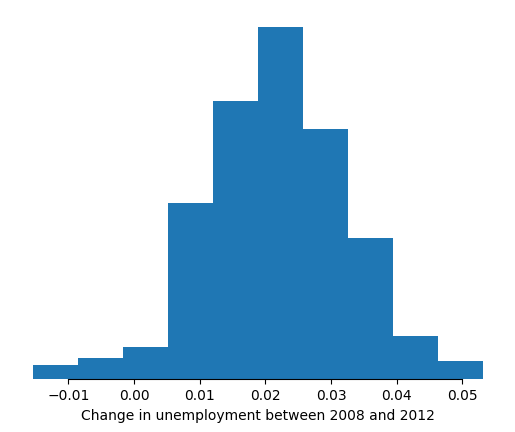

In [ ]:
del_12.delta_unemployed.hist()
# add xlabel
plt.xlabel('Change in unemployment between 2008 and 2012')
# remove the grid
plt.grid(False)
# despine
sns.despine(top=True, right=True, left=True, trim=10)
# remove ylabel and ticks
plt.yticks([])
plt.savefig(file_path + 'unemployment_change_2012.png')

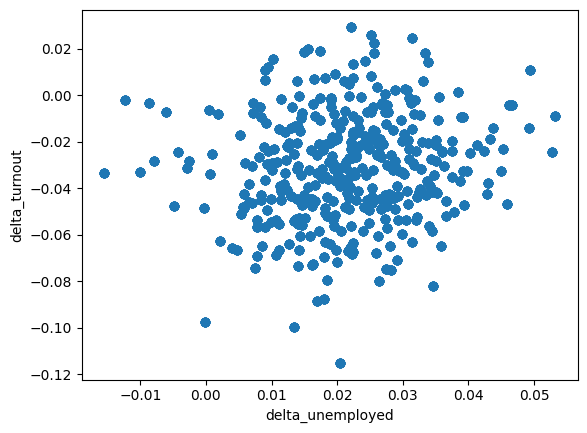

In [ ]:
# scatter turnout on the vertical and unemployment on the horizontal
plt.scatter(del_12['delta_unemployed'], del_12['delta_turnout']);
# axes
plt.xlabel('delta_unemployed')
plt.ylabel('delta_turnout');

In [ ]:
mod = smf.ols(formula='delta_turnout ~ delta_unemployed', data=del_12)
res = mod.fit(cov_type='HC0')  # Fit with robust standard errors
print(res.summary().tables[1])

                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0361      0.001    -42.169      0.000      -0.038      -0.034
delta_unemployed     0.2345      0.033      7.084      0.000       0.170       0.299


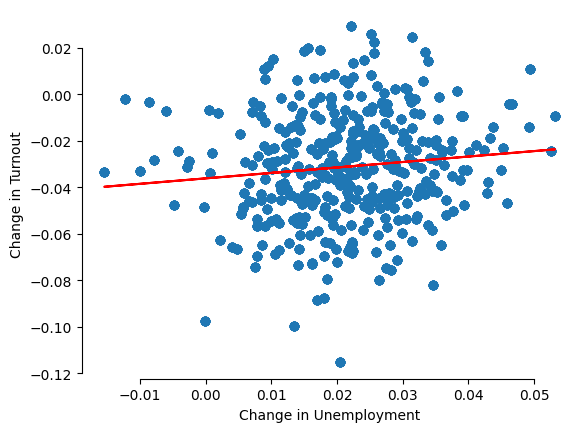

In [ ]:
# plot the model on the scatterplot
plt.scatter(del_12['delta_unemployed'], del_12['delta_turnout']);
plt.plot(del_12['delta_unemployed'], res.predict(), color='red');

# despine all four sides
sns.despine(top=True, right=True, trim=10)

# label axes
plt.xlabel('Change in Unemployment')
plt.ylabel('Change in Turnout');
plt.savefig(file_path + 'turnout_unemployment_change_2012.png')

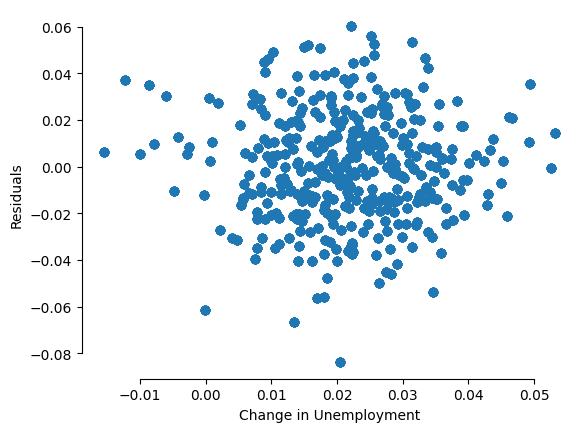

In [ ]:
# residual plot
plt.scatter(del_12['delta_unemployed'], res.resid);
plt.xlabel('Change in Unemployment')
plt.ylabel('Residuals');

# despine all four sides
sns.despine(top=True, right=True, trim=10)
plt.savefig(file_path + 'turnout_unemployment_change_2012_residuals.png')
#